<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/temp_hosting/clustering_with_rf_and%20Funda_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kneed --q

In [6]:
tker= ['ABBOTINDIA.NS',
'ACI.NS',
'CAMS.NS',
'COALINDIA.NS',
'EASEMYTRIP.NS',
'FINEORG.NS',
'INGERRAND.NS',
'LLOYDSME.NS',
'PGHL.NS',
'PGHH.NS',
'TATAELXSI.NS',
'TCS.NS',
'TIPSINDLTD.NS',]
START = '2018-01-01' #yyyy-mm-dd
#2022-05-13 #2022-05-02


[*********************100%%**********************]  13 of 13 completed
[*********************100%%**********************]  13 of 13 completed
[*********************100%%**********************]  13 of 13 completed
[*********************100%%**********************]  13 of 13 completed


<Axes: xlabel='Date'>

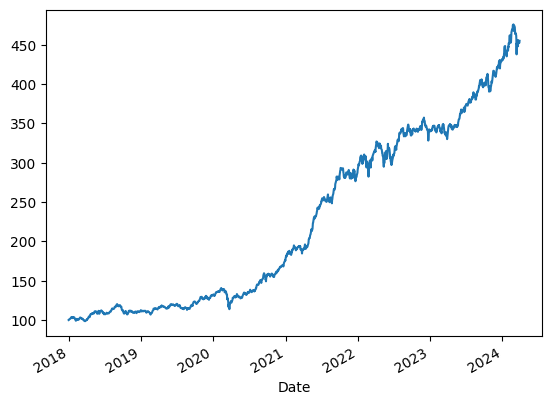

In [7]:
import pandas as pd
import yfinance as yf

def get_equal_weighted_index(tickers, var, start_date):
    """
    Calculates the equal-weighted index for a list of tickers over a specified period.

    Args:
        tickers (list): List of ticker symbols.
        var (str): Variable to use for calculation (e.g., "Close", "Open"). Default is "Close".
        start_date (str): Start date for data retrieval (YYYY-MM-DD).
        end_date (str): End date for data retrieval (YYYY-MM-DD).

    Returns:
        float: The final value of the equal-weighted index.
    """



    # Download historical data
    data = yf.download(tker, start=start_date)[var]

    # Calculate percentage returns
    returns = data.pct_change()
    weights = [1 / len(tickers)] * len(tickers)
     # Calculate index value
    index_value = 100  # Initial index value
    index_returns = returns.mul(weights).sum(axis=1)
    index_value = (1 + index_returns).cumprod() * index_value

    return index_value
var='Close'
nifty_close = get_equal_weighted_index(tker,var, START )
var='Open'
nifty_open = get_equal_weighted_index(tker,var, START)
var='High'
nifty_high = get_equal_weighted_index(tker,var, START)
var='Low'
nifty_low = get_equal_weighted_index(tker,var, START)
nifty=pd.concat([nifty_open,nifty_high,nifty_low,nifty_close],axis=1)
nifty.columns=["Open","High","Low","Close"]
nifty.Close.plot()

In [10]:
df = nifty.reset_index().copy()

# Distance from the moving averages
for m in [10, 20, 30, 50, 100]:
    df[f'feat_dist_from_ma_{m}'] = df['Close']/df['Close'].rolling(m).mean()-1

# Distance from n day max/min
for m in [3, 5, 10, 15, 20, 30, 50, 100]:
    df[f'feat_dist_from_max_{m}'] = df['Close']/df['High'].rolling(m).max()-1
    df[f'feat_dist_from_min_{m}'] = df['Close']/df['Low'].rolling(m).min()-1

# Price distance
for m in [1, 2, 3, 4, 5, 10, 15, 20, 30, 50, 100]:
    df[f'feat_price_dist_{m}'] = df['Close']/df['Close'].shift(m)-1



In [11]:
df = df.dropna()
df_train = df[df['Date'] < '2022-01-01'].reset_index(drop=True)
df_test = df[df['Date'] >= '2022-01-01'].reset_index(drop=True)

feat_cols = [col for col in df.columns if 'feat' in col]

## Begin Clustering Efforts

Optimal k: 9


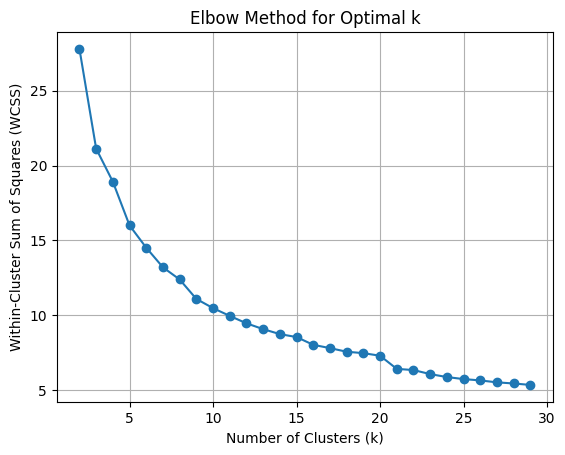

In [12]:
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from kneed import KneeLocator

x_train = df_train[feat_cols]

wcss = []
k_range = range(2, 30)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(x_train)
    wcss.append(kmeans.inertia_)

elbow_locator = KneeLocator(k_range, wcss, curve='convex', direction='decreasing')
optimal_k = elbow_locator.elbow

print(f'Optimal k: {optimal_k}')

plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

optimal_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
optimal_kmeans.fit(x_train)

df_train['cluster'] = optimal_kmeans.predict(x_train)

In [13]:
import plotly.express as px

df_plot = df_train[df_train['Date'] > '2012-01-01']

fig = px.scatter(
    df_plot,
    x='Date',
    y='Close',
    color='cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Training',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

In [26]:
# Analyze and interpret clusters
for i in range(9):
    cluster_data = df_train[df_train['cluster'] == i]
    print(f"Cluster {i}:\n", cluster_data[feat_cols].median())


Cluster 0:
 feat_dist_from_ma_10     -0.017240
feat_dist_from_ma_20     -0.046369
feat_dist_from_ma_30     -0.058921
feat_dist_from_ma_50     -0.063797
feat_dist_from_ma_100    -0.042722
feat_dist_from_max_3     -0.024271
feat_dist_from_min_3      0.012734
feat_dist_from_max_5     -0.033541
feat_dist_from_min_5      0.024375
feat_dist_from_max_10    -0.059265
feat_dist_from_min_10     0.028194
feat_dist_from_max_15    -0.086599
feat_dist_from_min_15     0.028194
feat_dist_from_max_20    -0.098157
feat_dist_from_min_20     0.028194
feat_dist_from_max_30    -0.113446
feat_dist_from_min_30     0.028194
feat_dist_from_max_50    -0.121315
feat_dist_from_min_50     0.028194
feat_dist_from_max_100   -0.121315
feat_dist_from_min_100    0.034360
feat_price_dist_1        -0.004767
feat_price_dist_2        -0.011523
feat_price_dist_3        -0.013339
feat_price_dist_4        -0.020505
feat_price_dist_5        -0.025352
feat_price_dist_10       -0.048484
feat_price_dist_15       -0.077875
feat_pri

In [15]:
import numpy as np

good_clusters=[0,5,6,7,8]

df_plot['good_cluster'] = np.where(df_plot['cluster'].isin(good_clusters), 5, df_plot['cluster'])

fig = px.scatter(
    df_plot,
    x='Date',
    y='Close',
    color='good_cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Training',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

In [16]:
df_test['cluster'] = optimal_kmeans.predict(df_test[feat_cols])

fig = px.scatter(
    df_test,
    x='Date',
    y='Close',
    color='cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Testing-- LOOK FOR BOTTOMS FORMING[ ***SEE * THIS * FOR * TRADING***]'
)
# [0,4,9] : transition points, [5,6,7]: uptrend , [1,2,3]: downtrend',
# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()


Absolutely! Here's a comprehensive table summarizing the characteristics and potential actions for all clusters (0 to 8). I've added Cluster 9 based on your request.

Cluster Name	Cluster Characteristics	Potential Actions	Important Considerations


Cluster 0	Prices below MAs, recent pullback	* Consider short-selling or waiting for a reversal	* Set stop-losses, downtrends can continue unexpectedly.


Cluster 1	Prices above MAs, clear uptrend	* Look for buying opportunities	* Confirm with other indicators, trends can weaken


Cluster 2	Prices well above MAs, strong upward momentum	* Potential good entry for long positions	* Be cautious of overbought conditions and potential pullbacks.


Cluster 3	Prices near MAs, consolidation	* Avoid trading unless clear breakout	* Focus on assets with clearer trends, risk of whipsaw movement


Cluster 4	Strong uptrend, prices well above MAs	* Look for buying opportunities, strong potential	* Confirm with other indicators, watch for pullbacks


Cluster 5	Moderate uptrend, prices closer to maximums	* Consider long positions, but with caution	* May indicate a weakening uptrend, use tighter stop-losses


Cluster 6	Consolidation, prices near MAs	* Avoid trading unless clear breakout occurs	* Focus on assets with clearer trends, risk of being whipsawed.


Cluster 7	Mixed signals, potential reversal	* May signal shorting opportunities or caution on longs	* Requires careful confirmation with other analysis.


Cluster 8	Very strong momentum, prices near recent highs	* Potential good entry for long positions	* Be aware of overbought conditions, set stop-losses.




# [0,4,9] : transition points, [5,6,7]: uptrend , [1,2,3]: downtrend',

In [37]:

good_clusters=[1,2,4,5,8]
df_test['good_cluster'] = np.where(df_test['cluster'].isin(good_clusters), 1,0)

fig = px.scatter(
    df_test,
    x='Date',
    y='Close',
    color='good_cluster',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Testing Set',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

## Quick Backtest

In [38]:
from plotly import graph_objects as go

df_test['pct_change'] = df_test['Close'].pct_change()
df_test['signal'] = df_test['good_cluster'].shift(1)

df_test['equity_cluster'] = np.cumprod(1+df_test['signal']*df_test['pct_change'])
df_test['equity_buy_and_hold'] = np.cumprod(1+df_test['pct_change'])

fig = go.Figure()

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_buy_and_hold'], name='Buy and Hold')
)

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_cluster'], name='Clustering')
)

fig.update_layout(
    title_text='Quick Clustering Backtest',
    legend={'x': 0, 'y':-0.05, 'orientation': 'h'},
    xaxis={'title': 'Date'},
    yaxis={'title': 'Multiple from Initial Investment'}
)

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Random Forest Layer

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

x_train = df_train[feat_cols]
y_train = np.where(df_train['cluster'].isin(good_clusters), 1, 0)

x_test = df_test[feat_cols]
y_test = np.where(df_test['cluster'].isin(good_clusters), 1, 0)

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
)

clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# Calculate accuracy and precision for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

# Calculate accuracy and precision for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Training Precision: {train_precision}')
print('')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')

Training Accuracy: 1.0
Training Precision: 1.0

Test Accuracy: 0.9421338155515371
Test Precision: 0.9681159420289855


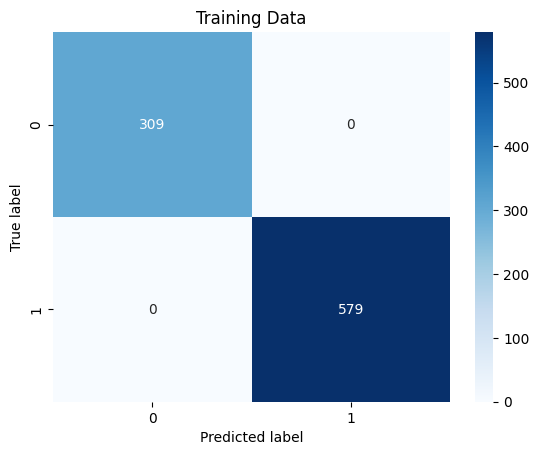

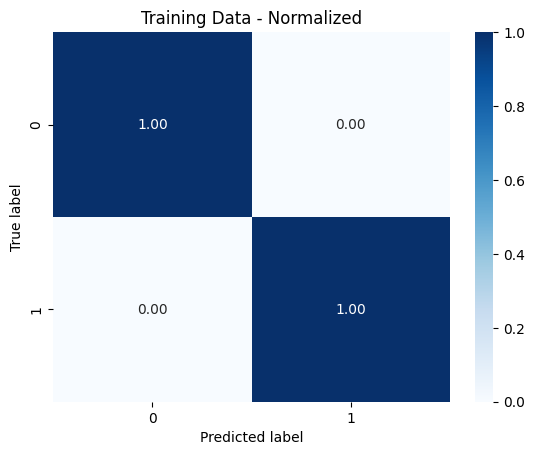

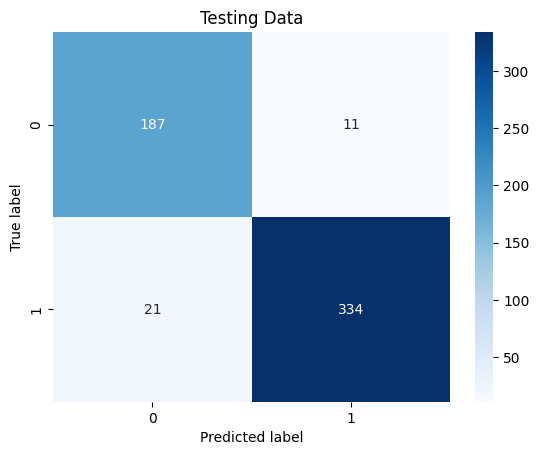

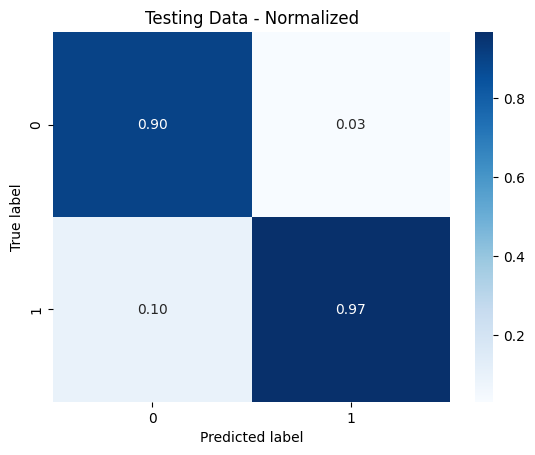

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title, normalize):

    if normalize:
        cm = confusion_matrix(y_true, y_pred, normalize='pred')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    else:
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return

plot_confusion_matrix(y_train, y_train_pred, title='Training Data', normalize=False)
plot_confusion_matrix(y_train, y_train_pred, title='Training Data - Normalized', normalize=True)

plot_confusion_matrix(y_test, y_test_pred, title='Testing Data', normalize=False)
plot_confusion_matrix(y_test, y_test_pred, title='Testing Data - Normalized', normalize=True)

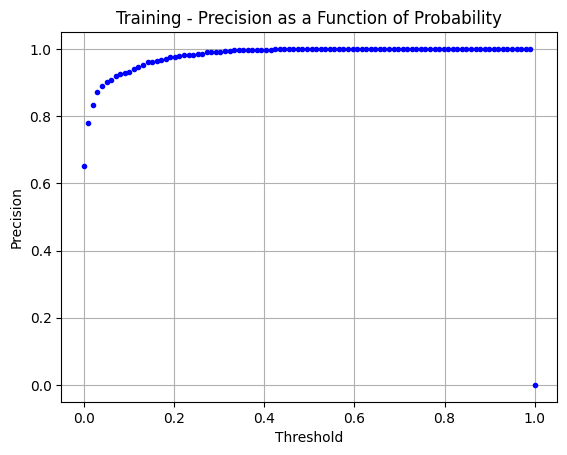

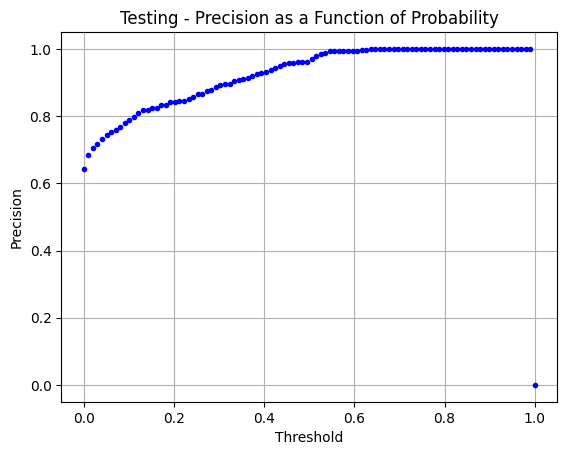

In [41]:
import numpy as np

def get_precision_curve(clf, x, y, title):

    y_scores = clf.predict_proba(x)[:, 1]

    thresholds = np.linspace(0, 1, 100)
    precision = []

    for t in thresholds:
        y_pred_threshold = (y_scores >= t).astype(int)
        precision.append(precision_score(y, y_pred_threshold, zero_division=0))

    plt.plot(thresholds, precision, 'b.')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title(title)
    plt.grid(True)
    plt.show()

    return

get_precision_curve(clf, x_train, y_train, 'Training - Precision as a Function of Probability')
get_precision_curve(clf, x_test, y_test, 'Testing - Precision as a Function of Probability')

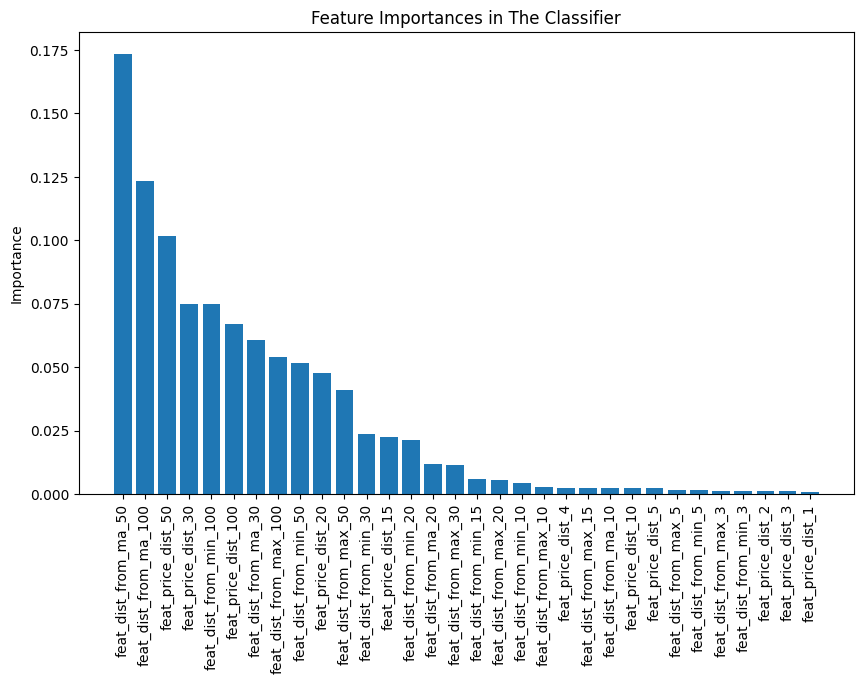

In [42]:
feature_importances = clf.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances in The Classifier")
plt.bar(range(x_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(x_train.shape[1]), x_train.columns[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.show()

In [43]:
import numpy as np

df_test['rf_pred'] = (clf.predict_proba(x_test)[:, 1] > 0.8).astype(int)

fig = px.scatter(
    df_test,
    x='Date',
    y='Close',
    color='rf_pred',
    color_continuous_scale='viridis',
    title='Cluster Analysis - Testing Set',
)

# Customize the axis labels
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Close')

# Show the plot
fig.show()

In [44]:
df_test['rf_signal'] = df_test['rf_pred'].shift(1)
df_test['equity_rf'] = np.cumprod(1+df_test['rf_signal']*df_test['pct_change'])

fig = go.Figure()

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_buy_and_hold'], name='Buy and Hold')
)

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_cluster'], name='Clustering')
)

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test['equity_rf'], name='Random Forest')
)

fig.update_layout(
    title_text='Clustering & RF Backtest',
    legend={'x': 0, 'y':-0.05, 'orientation': 'h'},
    xaxis={'title': 'Date'},
    yaxis={'title': 'Multiple from Initial Investment'}
)

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [45]:
def get_max_drawdown(col):
    drawdown = col/col.cummax()-1
    return 100*drawdown.min()

def calculate_cagr(col, n_years):
    cagr = (col.values[-1]/col.values[0])**(1/n_years)-1
    return 100*cagr

print('Maximum Drawdown Buy and Hold:', get_max_drawdown(df_test['equity_buy_and_hold']))
print('Maximum Drawdown Clustering:', get_max_drawdown(df_test['equity_cluster']))
print('Maximum Drawdown Random Forest:', get_max_drawdown(df_test['equity_rf']))

print('')

n_years = (df_test['Date'].max()-df_test['Date'].min()).days/365.25

print('CAGR Buy and Hold:', calculate_cagr(df_test['equity_buy_and_hold'].dropna(), n_years))
print('CAGR Clustering:', calculate_cagr(df_test['equity_cluster'].dropna(), n_years))
print('CAGR Random Forest:', calculate_cagr(df_test['equity_rf'].dropna(), n_years))

Maximum Drawdown Buy and Hold: -9.801705880835954
Maximum Drawdown Clustering: -7.665244450077491
Maximum Drawdown Random Forest: -7.735098189583811

CAGR Buy and Hold: 21.079341830658826
CAGR Clustering: 13.735689795246863
CAGR Random Forest: 9.092686774217373
